# Tuned VGG-like CNN for CIFAR-10

## 1. Imports and paths

In [1]:
import os
import json
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
import time

from tensorflow.keras import layers, models

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    CSVLogger,
    TensorBoard,
    Callback,
)

import seaborn as sns
import matplotlib.pyplot as plt

# Ensure project root is on sys.path so `utils` can be imported
cwd = Path.cwd()
if cwd.name.lower() == "notebooks":
    project_root = cwd.parent
elif cwd.name.lower() == "cifar10_project":
    project_root = cwd
elif (cwd / "cifar10_project").is_dir():
    project_root = cwd / "cifar10_project"
else:
    project_root = None

if project_root is not None and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from utils.ml_utils import (
    random_cutout,
    evaluate_and_log_model,
    format_duration,
    predict_and_resolve_labels,
    compute_confusion_matrix,
    build_classification_report,
    plot_confusion_matrix_notebook01,
    plot_training_curves_notebook01,
)

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU(s) detectada(s): {len(gpus)}")
else:
    print("Nenhuma GPU detectada. A correr em CPU.")


2026-02-20 13:51:41.952486: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-20 13:51:41.983164: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-20 13:51:42.445291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


GPU(s) detectada(s): 1


2026-02-20 13:51:42.471109: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-20 13:51:42.506000: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-20 13:51:42.506045: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
PROJECT_ROOT = os.getcwd()
if os.path.basename(PROJECT_ROOT).lower() == 'notebooks':
    PROJECT_ROOT = os.path.dirname(PROJECT_ROOT)
elif os.path.basename(PROJECT_ROOT).lower() != 'cifar10_project':
    candidate = os.path.join(PROJECT_ROOT, 'cifar10_project')
    if os.path.isdir(candidate):
        PROJECT_ROOT = candidate

DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')
MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')
REPORTS_DIR = os.path.join(PROJECT_ROOT, 'reports')
LOGS_ROOT = os.path.join(REPORTS_DIR, 'logs')

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)
os.makedirs(LOGS_ROOT, exist_ok=True)

data_path = os.path.join(PROCESSED_DIR, 'cifar10_processed.npz')
log_dir = os.path.join(LOGS_ROOT, 'logs_03_tuned')
performance_report_path = os.path.join(DATA_DIR, 'model_performance_report.csv')
os.makedirs(log_dir, exist_ok=True)

print("Data path:", data_path)
print("Log dir:", log_dir)
print("Performance report path:", performance_report_path)


Data path: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/data/processed/cifar10_processed.npz
Log dir: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/reports/logs/logs_03_tuned
Performance report path: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/data/model_performance_report.csv


## 2. Load processed data and convert labels to one-hot encoding

In [3]:
data = np.load(data_path)

x_train = data["x_train"]
y_train = data["y_train"]
x_val   = data["x_val"]
y_val   = data["y_val"]
x_test  = data["x_test"]
y_test  = data["y_test"]

print(x_train.shape, y_train.shape)
print(x_val.shape,   y_val.shape)
print(x_test.shape,  y_test.shape)
print("x_train range:", x_train.min(), x_train.max())
print("x_val range:", x_val.min(), x_val.max())
print("x_test range:", x_test.min(), x_test.max())


(40000, 32, 32, 3) (40000, 1)
(10000, 32, 32, 3) (10000, 1)
(10000, 32, 32, 3) (10000, 1)
x_train range: 0.0 1.0
x_val range: 0.0 1.0
x_test range: 0.0 1.0


In [ ]:
num_classes = 10

# Convert integer labels (shape (N,1) or (N,)) to one-hot
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val,   num_classes)
y_test = tf.keras.utils.to_categorical(y_test,  num_classes)


## 3. Data augmentation (with Cutout) and generators

In [5]:
CUTOUT_MAX_HOLES = 1
CUTOUT_MIN_SIZE = 4
CUTOUT_MAX_SIZE = 8

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    preprocessing_function=lambda img: random_cutout(
        img,
        max_holes=CUTOUT_MAX_HOLES,
        min_size=CUTOUT_MIN_SIZE,
        max_size=CUTOUT_MAX_SIZE,
    ),
)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

batch_size = 64

train_generator = train_datagen.flow(
    x_train, y_train, batch_size=batch_size, shuffle=True
)
val_generator = val_datagen.flow(
    x_val, y_val, batch_size=batch_size, shuffle=False
)
test_generator = test_datagen.flow(
    x_test, y_test, batch_size=batch_size, shuffle=False
)


## 4. Tuned VGG-BN model (4 blocks)

In [7]:
def build_vgg_bn_tuned(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Block 1: 32
        layers.Conv2D(32, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Conv2D(32, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2: 64
        layers.Conv2D(64, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Conv2D(64, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.30),

        # Block 3: 128
        layers.Conv2D(128, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Conv2D(128, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.40),

        # Block 4: 256 (novo bloco)
        layers.Conv2D(256, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Conv2D(256, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.40),

        # Classifier
        layers.Flatten(),
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation="softmax"),
    ])
    return model

model = build_vgg_bn_tuned()
model.summary()


2026-02-20 13:51:46.498334: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-20 13:51:46.498392: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-20 13:51:46.498407: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-20 13:51:46.591467: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-20 13:51:46.591509: I external/local_xla/xla/stream_executor

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 128)      │             

 Total params: 1,442,090 (5.50 MB)

 Trainable params: 1,439,658 (5.49 MB)

 Non-trainable params: 2,432 (9.50 KB)

## 5. Loss with label smoothing + AdamW + CosineDecay

In [ ]:
epochs = 200
steps_per_epoch = len(x_train) // batch_size

initial_lr = 4e-4

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=epochs * steps_per_epoch,
)

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=5e-4,
)

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0.05,
)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"],
)


## 6. Experiment logger (CSV)

In [9]:
def log_model_performance(model, model_name, test_gen, history, train_time_sec, csv_path):
    """Backward-compatible wrapper around the reusable utility logger."""
    print(f"📊 Extracting final metrics for {model_name}...")
    if train_time_sec is not None:
        print(f"⏱️ Train time: {format_duration(train_time_sec)} ({train_time_sec:.2f} sec)")

    row = evaluate_and_log_model(
        model=model,
        model_name=model_name,
        data=test_gen,
        csv_path=csv_path,
        history=history,
        train_time_sec=train_time_sec,
        average="macro",
        verbose=0,
    )
    print(f"✅ Success! Performance log updated at: {csv_path}")
    return row

## 7. Callbacks: EarlyStopping, ModelCheckpoint, TensorBoard, CSVLogger

In [10]:
checkpoint_path = os.path.join(MODELS_DIR, "vgg_bn_tuned_best.keras")
csv_log_path = os.path.join(DATA_DIR, "vgg_bn_tuned_history.csv")

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,
    verbose=1,
)

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
)

csv_logger = CSVLogger(csv_log_path, append=False)

tensorboard_cb = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    profile_batch="100,110",
)

callbacks = [
    early_stop,
    checkpoint,
    csv_logger,
    tensorboard_cb,
]

2026-02-20 13:51:47.013047: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2026-02-20 13:51:47.013093: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2026-02-20 13:51:47.013139: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1239] Profiler found 1 GPUs
2026-02-20 13:51:47.023336: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2026-02-20 13:51:47.023457: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1364] CUPTI activity buffer flushed


## 8. Training

In [11]:
start_time = time.time()

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1,
)

end_time = time.time()
train_duration = end_time - start_time
print(f"Training time: {format_duration(train_duration)} ({train_duration:.2f} sec)")

log_model_performance(
    model=model,
    model_name="CNN - VGG-like Tuned",
    test_gen=test_generator,
    history=history,
    train_time_sec=train_duration,
    csv_path=performance_report_path,
)


Epoch 1/200


I0000 00:00:1771595510.464627   18664 service.cc:145] XLA service 0x79b82801f160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771595510.464665   18664 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2026-02-20 13:51:50.569130: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-20 13:51:51.009328: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  8/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.1073 - loss: 2.8830  

I0000 00:00:1771595517.768643   18664 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


108/625 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.1440 - loss: 2.6392

2026-02-20 13:51:59.276125: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2026-02-20 13:51:59.276158: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2026-02-20 13:51:59.443507: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2026-02-20 13:51:59.456492: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1364] CUPTI activity buffer flushed
2026-02-20 13:51:59.467218: I external/local_xla/xla/backends/profiler/gpu/cupti_collector.cc:540]  GpuTracer has collected 3226 callback api events and 3212 activity events. 
2026-02-20 13:51:59.470497: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2286 - loss: 2.2568
Epoch 1: val_loss improved from None to 1.82120, saving model to /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/models/vgg_bn_tuned_best.keras

Epoch 1: finished saving model to /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/models/vgg_bn_tuned_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.2951 - loss: 2.0135 - val_accuracy: 0.3553 - val_loss: 1.8212
Epoch 2/200
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4165 - loss: 1.6938
Epoch 2: val_loss improved from 1.82120 to 1.46146, saving model to /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/models/vgg_bn_tuned_best.keras

Epoch 2: finished saving model to /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_iron

{'model_name': 'CNN - VGG-like Tuned',
 'num_params': 1442090,
 'train_time_sec': 1680.41,
 'train_time': '28 min 00 sec',
 'timestamp': '2026-02-20 14:19',
 'accuracy': 0.8819,
 'precision': 0.883584645047278,
 'recall': 0.8818999999999999,
 'f1': 0.8805139529854417,
 'support': 10000,
 'final_accuracy': 0.8972499966621399,
 'final_loss': 0.5557119846343994,
 'final_val_accuracy': 0.8851000070571899,
 'final_val_loss': 0.5833091139793396,
 'epochs_trained': 176,
 'final_learning_rate': 1.404469003318809e-05,
 'test_loss': 0.595336377620697}

## 9. Test evaluation

In [12]:
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Test accuracy (best weights): {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

Test accuracy (best weights): 0.8819
Test loss: 0.5953


## 10. Plots for report (accuracy and loss curves)

Generating predictions...


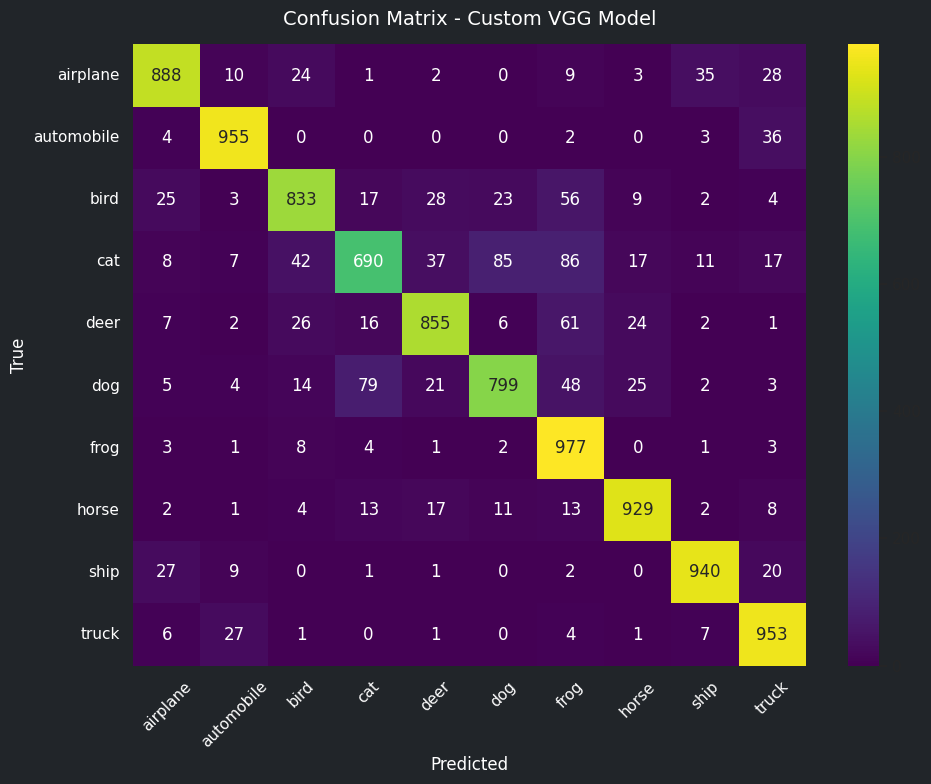


Classification Report (VGG):
              precision    recall  f1-score   support

    airplane     0.9108    0.8880    0.8992      1000
  automobile     0.9372    0.9550    0.9460      1000
        bird     0.8750    0.8330    0.8535      1000
         cat     0.8404    0.6900    0.7578      1000
        deer     0.8879    0.8550    0.8711      1000
         dog     0.8629    0.7990    0.8297      1000
        frog     0.7766    0.9770    0.8654      1000
       horse     0.9216    0.9290    0.9253      1000
        ship     0.9353    0.9400    0.9377      1000
       truck     0.8882    0.9530    0.9194      1000

    accuracy                         0.8819     10000
   macro avg     0.8836    0.8819    0.8805     10000
weighted avg     0.8836    0.8819    0.8805     10000



In [13]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print("Generating predictions...")
y_true, y_pred = predict_and_resolve_labels(model=model, data=test_generator, verbose=0)

cm = compute_confusion_matrix(y_true, y_pred)
plot_confusion_matrix_notebook01(
    confusion=cm,
    class_names=class_names,
    title='Confusion Matrix - Custom VGG Model',
)

print("\nClassification Report (VGG):")
print(build_classification_report(y_true, y_pred, target_names=class_names))

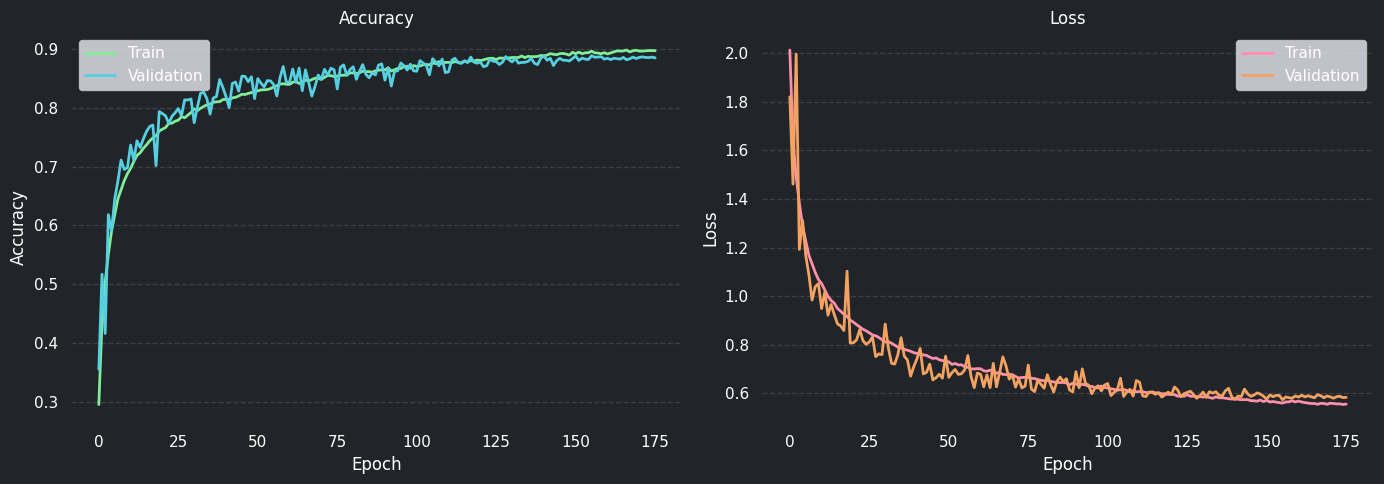

Saved curves to: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/reports/vgg_bn_tuned_curves.png


In [14]:
curves_path = os.path.join(REPORTS_DIR, "vgg_bn_tuned_curves.png")
plot_training_curves_notebook01(
    history=history,
    save_path=curves_path,
)

print("Saved curves to:", curves_path)

## 11. Save model

In [15]:
final_model_path = os.path.join(MODELS_DIR, "vgg_bn_tuned_final.keras")
model.save(final_model_path)
print("Saved:", final_model_path)


Saved: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/models/vgg_bn_tuned_final.keras
